In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re

抓股票代號

In [2]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [3]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(41) #固定種子複現結果
US10_Stocks = random.sample(US100_stocks, 10)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y", start="2018-01-01", end="2020-01-01")
    US10_stocks_prices[stock] = historical_data

In [4]:
US10_Stocks

['PM', 'NKE', 'ACN', 'ABBV', 'COP', 'RTX', 'CVS', 'AMD', 'SBUX', 'CMCSA']

利用股價生成日報酬

In [5]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [6]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)

In [7]:
pd.DataFrame(US10_stocks_returns)

,PM,NKE,ACN,ABBV,COP,RTX,CVS,AMD,SBUX,CMCSA
0,-0.001245,-0.000158,0.004616,0.015649,0.018438,0.014669,-0.004352,0.051913,0.018740,-0.016070
1,-0.007577,-0.000630,0.011840,-0.005703,0.011537,0.003153,0.026366,0.049351,0.003747,0.006434
2,0.008022,0.008512,0.008249,0.017408,-0.001930,0.008586,0.044190,-0.019802,0.011539,0.009098
3,-0.001534,0.008909,0.007991,-0.016022,0.010197,0.009501,-0.008668,0.033670,-0.005033,-0.013645
4,0.007202,-0.007126,0.003335,0.007539,0.008180,0.010917,-0.001029,-0.037459,-0.002192,0.003212
...,...,...,...,...,...,...,...,...,...,...
497,0.001046,0.001000,0.003700,-0.004432,0.001084,-0.001669,0.001748,0.023757,0.003287,0.009751
498,-0.000929,0.005692,0.002079,-0.000223,0.005103,0.007622,-0.000402,0.001934,-0.004971,0.009881
499,0.003255,0.008539,0.000802,-0.007013,-0.000308,-0.002853,-0.001074,-0.009650,0.000568,0.002891
500,-0.007068,-0.007581,-0.007445,-0.007623,-0.005694,-0.002662,-0.009409,-0.014292,-0.007829,0.001774


計算統計數字

In [8]:
#計算平均報酬
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]

mean_returns = pd.Series(US10_stocks_expected_return)
mean_returns

PM      -0.088484
NKE      0.630801
ACN      0.411037
ABBV    -0.012384
COP      0.223359
RTX      0.221759
CVS      0.074970
AMD      3.176685
SBUX     0.590271
CMCSA    0.136487
dtype: float64

In [9]:
#共變異數矩陣
cov_matrix = pd.DataFrame(US10_stocks_returns).cov()*502
cov_matrix

,PM,NKE,ACN,ABBV,COP,RTX,CVS,AMD,SBUX,CMCSA
PM,0.135944,0.018837,0.024063,0.028192,0.018038,0.028094,0.029845,0.016164,0.024238,0.029091
NKE,0.018837,0.128383,0.048904,0.049592,0.050735,0.050895,0.030443,0.107021,0.037960,0.046932
ACN,0.024063,0.048904,0.082445,0.052625,0.043381,0.049465,0.034749,0.091932,0.040621,0.041273
ABBV,0.028192,0.049592,0.052625,0.196750,0.046628,0.043715,0.051900,0.093616,0.023809,0.043345
COP,0.018038,0.050735,0.043381,0.046628,0.165083,0.050311,0.034815,0.102140,0.020140,0.041805
RTX,0.028094,0.050895,0.049465,0.043715,0.050311,0.093372,0.040433,0.093291,0.034326,0.043362
CVS,0.029845,0.030443,0.034749,0.051900,0.034815,0.040433,0.150110,0.079602,0.028781,0.041457
AMD,0.016164,0.107021,0.091932,0.093616,0.102140,0.093291,0.079602,0.680896,0.067360,0.053845
SBUX,0.024238,0.037960,0.040621,0.023809,0.020140,0.034326,0.028781,0.067360,0.091627,0.031602
CMCSA,0.029091,0.046932,0.041273,0.043345,0.041805,0.043362,0.041457,0.053845,0.031602,0.114219


切線法

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


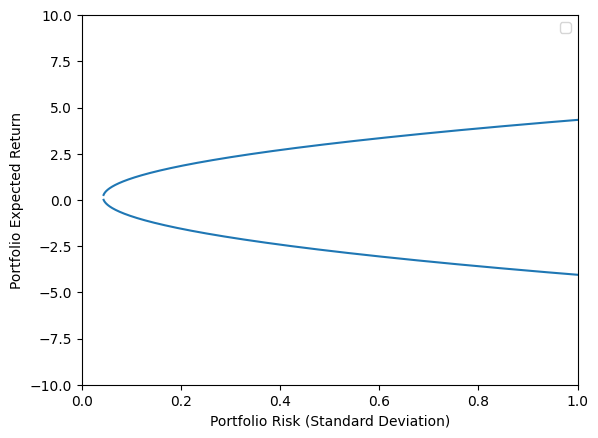

In [10]:
Rbar = mean_returns.values

#建立不同的無風險利率
Rfs = np.linspace(-6, 6, 100000)

weights = []
for Rf in Rfs:
    Rf = np.full((Rbar.shape[0], 1), Rf)
    Rbar = Rbar.reshape(10, 1)
    f = Rbar - Rf
    V_inv = np.linalg.inv(cov_matrix)
    Z = np.dot(V_inv,f)
    # 計算 V^(-1) * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    ones_vector = np.ones((10, 1))
    # 計算 Z.T * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    Z_transpose = Z.T
    Z_dot_ones = np.dot(Z_transpose, ones_vector)

    # 最後計算 X
    X = Z / Z_dot_ones
    weights.append(X)

t_vars = []
t_fp = []
# 如果Y軸的值想要用成超額報酬在fp那裡減掉Rf即可
# 切線法的Rf變動是為了求取Weights,只是為了得到Weights,Rf取定值後即可得到Excess Return.
rf = 0.004
for weight in weights:
    var = np.dot(np.dot(weight.T,cov_matrix.values), weight)
    t_vars.append(float(var))
    t_fp.append(float(np.dot(weight.T, Rbar))-rf)

plt.plot(t_vars, t_fp)
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Expected Return')
plt.legend()
plt.ylim(-10, 10)
plt.xlim(0, 1)

plt.show()

火腿法

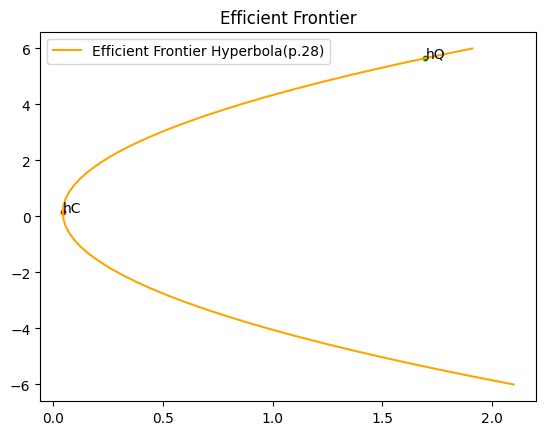

In [11]:
#代講義推導出的公式(p.28)

f = mean_returns.values
f = f.reshape(10, 1)
#建立不同的無風險利率
Rfs = np.linspace(-6, 6, 50)

weights = []
e = np.ones((10, 1))

for u in Rfs:
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    A = e.T @ V_inv @ e
    B = e.T @ V_inv @ f
    C = f.T @ V_inv @ f
    D = (A @ C) - (B ** 2)
    _lambda = (C - (u * B)) / D
    _gamma = ((A * u) - B) / D
    h = (_lambda * V_inv @ e) + (_gamma * V_inv @ f)
    weights.append(h)

hC = (np.linalg.inv(cov_matrix.values) @ e) / (e.T @ np.linalg.inv(cov_matrix.values) @ e)
hQ = (np.linalg.inv(cov_matrix.values) @ f) / (f.T @ np.linalg.inv(cov_matrix.values) @ e)

hC_point = (np.dot(hC.T, cov_matrix.values) @ hC, np.dot(hC.T, f))
hQ_point = (np.dot(hQ.T, cov_matrix.values) @ hQ, np.dot(hQ.T, f))

vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

fig, ax = plt.subplots()
# 繪製hQ跟hC
plt.title('Efficient Frontier')
plt.scatter(*hC_point, c='red', s=10)
plt.annotate('hC', xy=hC_point)
plt.scatter(*hQ_point, c='green', s=10)
plt.annotate('hQ', xy=hQ_point)


plt.plot(vars, fp, label= 'Efficient Frontier Hyperbola(p.28)', c='orange')
plt.legend()



C:\Users\USER\AppData\Local\Temp\ipykernel_2324\662884244.py:43: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = opt.minimize(objective, init_h, method='SLSQP', bounds=bound, constraints=conditions)


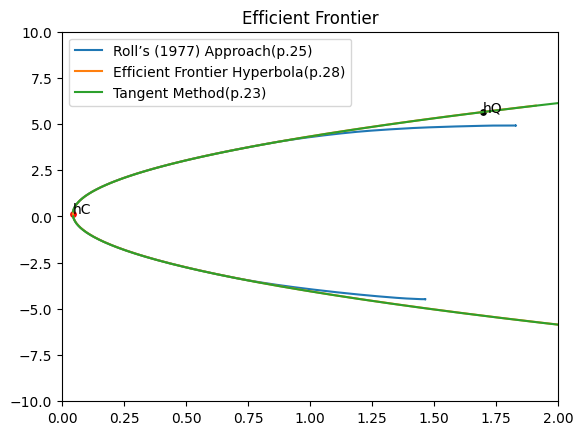

In [12]:
#火腿法的規劃求解(p.25)

f = mean_returns.values

#定義取得fp及Varp的函數
def get_fp(h):
    return np.dot(h.T, f)

def get_Varp(h):
    return np.dot(np.dot(h.T, cov_matrix.values), h)

#引入規劃求解套件
import scipy.optimize as opt

#目標式
def objective(h):
    return 0.5*get_Varp(h)


#定義限制式1，h的總和要為1
def constraint1(h):
    return np.sum(h) - 1

#定義限制式2，fp要等於我們設定的目標報酬率(即Rf)
def constraint2(h):
    return get_fp(h) - Rf

#設定h的權重要在-1~1之間
bound = tuple((-1,1) for _ in range(f.shape[0]))


#將兩個限制式打包成一個tuple
conditions = ({'type':'eq', 'fun':constraint1}, 
              {'type':'eq', 'fun':constraint2})

#隨便給一個求解的起始值(每個都先給0.1)
init_h = np.full((f.shape[0], 1), 1/f.shape[0])

#先設定Rf範圍，再各別求最佳解
Rfs = np.linspace(-6, 6, 1000)
h_weights = []
for idx, Rf in enumerate(Rfs):
    result = opt.minimize(objective, init_h, method='SLSQP', bounds=bound, constraints=conditions)
    h_weights.append(result.x)

fig, ax = plt.subplots()

plt.plot([get_Varp(h) for h in h_weights], [get_fp(h) for h in h_weights], label='Roll’s (1977) Approach(p.25)')
plt.plot(vars, fp, label= 'Efficient Frontier Hyperbola(p.28)')

plt.plot(t_vars, t_fp, label='Tangent Method(p.23)')


# 繪製hQ跟hC
plt.title('Efficient Frontier')
plt.scatter(*hC_point, c='red', s=15)
plt.annotate('hC', xy=hC_point)
plt.scatter(*hQ_point, c='black', s=15)
plt.annotate('hQ', xy=hQ_point)


plt.xlim(0, 2)
plt.ylim(-10, 10)
plt.legend()